初始化环境

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

In [76]:
row_data = spark.read.csv(path="hdfs://localhost:9000/user/bdlab/lab2/USCensus1990.data.txt",header=True,inferSchema=True)

data = row_data.rdd

# 抽样测试
* 选取最佳k值
* 初始化聚类中心

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
sample_data = row_data.sample(0.01) # 抽样 1%
sample_pd = sample_data.toPandas()

In [8]:
sample_pd = sample_pd.iloc[:,1:].values # 第一列无用

样本数据标准化

In [47]:
from sklearn.preprocessing import StandardScaler
sample_pd = StandardScaler().fit_transform(sample_pd)

In [48]:
# 保存抽样
np.savetxt("sample_std_array.txt",sample_pd)

In [4]:
# 加载抽样
sample_pd = np.loadtxt("sample_std_array.txt")

In [49]:
sample_pd.shape

(24628, 68)

In [5]:
from sklearn.cluster import KMeans

In [51]:
SSE = []  # 存放每次结果的误差平方和
for k in range(1,13):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(sample_pd)
    SSE.append(estimator.inertia_)
    print("k={}, SSE={}".format(k,SSE[-1]))

k=1, SSE=1674704.0000000002
k=2, SSE=1328927.7399816418
k=3, SSE=1135042.307368246
k=4, SSE=1067560.372383153
k=5, SSE=1018398.7434226715
k=6, SSE=971948.8169754281
k=7, SSE=943190.3577651557
k=8, SSE=923002.3750831345
k=9, SSE=881972.0964427008
k=10, SSE=870906.5903082998
k=11, SSE=857028.3218245438
k=12, SSE=824949.4245692719


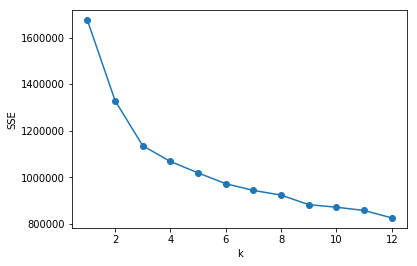

In [52]:
plt.xlabel("k")
plt.ylabel("SSE")
plt.plot(range(1,13),SSE,marker='o')

                根据手肘法,选定k=3或4

In [6]:
estimator = KMeans(n_clusters=3)  # 构造聚类器
estimator.fit(sample_pd)
km_result = estimator.labels_
km_center = estimator.cluster_centers_ # 作为整体数据初始聚类中心

PCA降维,绘图

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
sample_pca = pca.fit_transform(sample_pd)

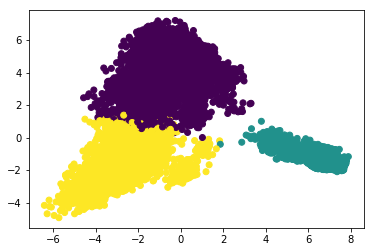

In [11]:
plt.scatter(sample_pca[:,0],sample_pca[:,1],c=km_result)
plt.show()

            经测试 k=3 有较好分类效果



# 聚类

k = 期望簇数

delta = 可接受的收敛误差

max_iter = 最大迭代次数

data = 输入数据


1. 初始化质心

2. map：对每个向量，计算当前向量到各中心的距离，更新最近的中心
    
    输入：向量
    
    输出：（最近的中心，向量）

3. reduce：根据所有map输出，重新计算所有簇的平均值，重新创建质心
    
    输入：iterable 向量
    
    输出：key.id，新质心= avg(list向量)
    
4. change:比较新旧质心的变化，若变化量小于delta，判定收敛，算法终止

    输入：新质心，旧质心
    
    输出：新旧质心距离（向量）
      
       

In [27]:
k = 3
delta = 0.0001
max_iter = 30
initial_centroids = km_center

In [81]:
data = data.map(lambda x:x[1:])

In [14]:
current_centroids = initial_centroids

定义功能函数

In [25]:
# 计算两向量的欧氏距离
def eucDis(x,y):
    sumdis = 0
    for i,j in zip(x,y):
        sumdis += (i-j)**2
    return sumdis**0.5

# Vector 求和
def vecAdd(x):
    vecres=[]
    for i in range(len(x[0])):
        sumi = 0
        for j in x:
            sumi += j[i]
        vecres.append(sumi)
    return vecres

# Vector 除以整数
def vecDiv(vec,y):
    return [x/y for x in vec]

# 计算质心变化
def change(new,current):
    new_d = eucDis(vecAdd(new),vecAdd(current))
    return new_d if new_d>=0 else -new_d

mapper 对Vector分类

In [38]:
def nearest_mapper(tup):
    """
    Parameters:
        tup: input tuple (id,(vec,1))
    Returns:
        nearest: the nearest center id
        x: input x
        1: counter
    """
    x = tup[1][0]
    nearest = -1
    nearest_dis = -1
    for i in range(k):
        dis = eucDis(x,current_centroids[i])
        if nearest == -1:
            nearest = i
            nearest_dis = dis
        else:
            if dis<nearest_dis:
                nearest = i
                nearest_dis = dis 
    return (nearest,(x,1))

reducer 重新计算质心

In [17]:
def center_reducer(x,y):
    return (vecAdd([x[0],y[0]]),x[1]+y[1])

In [70]:
center_reducer((initial_centroids,1),(initial_centroids,1))[0][1].shape

(68,)

In [82]:
sample_data_rdd = data.sample(False,0.001)

sample_data_rdd.count()

2466

In [87]:
def k_means(data=data,delta = 0.0001,max_iter = 30,initial_centroids = km_center):
    # 初始化迭代计数器
    iter_cnt = 0
    # 初始化簇质心
    global current_centroids
    current_centroids = initial_centroids.copy()
    new_centroids = initial_centroids.copy()
    # 调整数据格式作为输入
    data = data.map(lambda x:(0,(x,1)))
    # 迭代
    while True:
        data = data.map(nearest_mapper)
        cent_list = data.reduceByKey(center_reducer).collect()
        print(cent_list)
        for x,y in cent_list: # (id,(vec,cnt))
            new_centroids[x] = vecDiv(y[0],y[1])
        print(new_centroids)
        iter_cnt +=1
        loss = change(new_centroids,current_centroids)
        # TODO: 输出迭代信息
        print("Iter {} complete, loss={}".format(iter_cnt,loss))
        if loss<delta :
            # 收敛
            print("收敛,算法结束.")
            break;
        if iter_cnt >= max_iter :
            # 达到最大迭代次数
            print("达到迭代上限,算法结束")
            break;
        current_centroids = new_centroids.copy()
    result = data.map(lambda x:x[0][0])
    return result

In [88]:
k_means(data=sample_data_rdd)

[(0, ([3133, 1995, 782, 104, 158, 346, 0, 913, 936, 126, 7, 1366, 52, 164, 0, 290, 70, 6, 1, 118, 259, 60, 108, 30, 1145, 16, 1040, 975, 581, 4, 0, 2048, 757, 1005, 563, 3, 1024, 152, 933, 631, 1404, 147, 1031, 47, 0, 0, 3213, 0, 894, 9616, 6, 1330, 582, 619, 4, 390, 14, 9, 1466, 0, 7, 81, 1018, 1064, 47, 4852, 2712, 85], 560)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([5372, 3905, 1893, 163, 339, 2710, 3338, 2394, 2442, 245, 50, 1386, 152, 3670, 3362, 451, 2108, 113, 29, 324, 49, 15, 40, 60, 8093, 41, 2334, 182, 1516, 37, 2006, 4395, 1827, 2448, 3549, 1, 2428, 346, 2347, 1424, 1662, 3455, 1822, 89, 0, 1187, 1704, 0, 3559, 21488, 12, 3178, 1202, 1448, 42, 527, 27, 17, 250, 3567, 84, 1936, 1259, 1293, 27, 13424, 13

[(0, ([3244, 2185, 818, 111, 128, 370, 0, 947, 975, 119, 8, 1385, 44, 251, 0, 225, 108, 9, 2, 124, 260, 60, 106, 34, 1185, 17, 1114, 1000, 686, 3, 0, 2129, 804, 1056, 662, 3, 1072, 119, 985, 669, 1421, 214, 1182, 64, 0, 0, 3307, 0, 957, 9611, 18, 1436, 606, 668, 2, 396, 14, 9, 1489, 0, 7, 120, 1033, 1106, 48, 5090, 2730, 86], 596)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([5261, 3715, 1857, 156, 369, 2686, 3338, 2360, 2403, 252, 49, 1367, 160, 3583, 3362, 516, 2070, 110, 28, 318, 48, 15, 42, 56, 8053, 40, 2260, 157, 1411, 38, 2006, 4314, 1780, 2397, 3450, 1, 2380, 379, 2295, 1386, 1645, 3388, 1671, 72, 0, 1187, 1610, 0, 3496, 21493, 0, 3072, 1178, 1399, 44, 521, 27, 17, 227, 3567, 84, 1897, 1244, 1251, 26, 13186,

[(0, ([3221, 2240, 844, 151, 30, 458, 15, 957, 988, 76, 10, 1374, 18, 317, 12, 73, 139, 9, 3, 123, 254, 59, 104, 33, 1364, 16, 1137, 981, 715, 4, 7, 2135, 802, 1066, 762, 3, 1081, 28, 998, 675, 1389, 274, 1193, 67, 0, 8, 3243, 0, 990, 8328, 17, 1474, 614, 677, 2, 387, 15, 9, 1455, 22, 9, 153, 1013, 1103, 47, 5133, 2637, 89], 598)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([5284, 3660, 1831, 116, 467, 2598, 3323, 2350, 2390, 295, 47, 1378, 186, 3517, 3350, 668, 2039, 110, 27, 319, 54, 16, 44, 57, 7874, 41, 2237, 176, 1382, 37, 1999, 4308, 1782, 2387, 3350, 1, 2371, 470, 2282, 1380, 1677, 3328, 1660, 69, 0, 1179, 1674, 0, 3463, 22776, 1, 3034, 1170, 1390, 44, 530, 26, 17, 261, 3545, 82, 1864, 1264, 1254, 27, 13143, 

[(0, ([3582, 2784, 956, 171, 0, 653, 332, 1141, 1176, 72, 13, 1439, 10, 617, 294, 0, 273, 21, 11, 138, 256, 60, 103, 37, 1834, 18, 1312, 936, 843, 4, 228, 2487, 924, 1246, 1123, 3, 1258, 0, 1162, 770, 1499, 540, 1318, 65, 0, 126, 3188, 0, 1234, 8434, 15, 1746, 647, 766, 5, 426, 20, 12, 1388, 310, 12, 336, 1084, 1162, 47, 5994, 2625, 98], 685)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([4923, 3116, 1719, 96, 497, 2403, 3006, 2166, 2202, 299, 44, 1313, 194, 3217, 3068, 741, 1905, 98, 19, 304, 52, 15, 45, 53, 7404, 39, 2062, 221, 1254, 37, 1778, 3956, 1660, 2207, 2989, 1, 2194, 498, 2118, 1285, 1567, 3062, 1535, 71, 0, 1061, 1729, 0, 3219, 22670, 3, 2762, 1137, 1301, 41, 491, 21, 14, 328, 3257, 79, 1681, 1193, 1195, 

[(0, ([5427, 3757, 1621, 167, 0, 1763, 1914, 2051, 2103, 99, 30, 1833, 35, 2247, 1928, 0, 1242, 67, 24, 263, 236, 59, 98, 54, 5344, 31, 2188, 823, 1350, 15, 1081, 4107, 1580, 2157, 2588, 4, 2159, 0, 2049, 1266, 1999, 2085, 1739, 66, 0, 697, 3346, 0, 2708, 12096, 14, 2864, 1062, 1268, 12, 592, 29, 17, 1217, 1987, 46, 1182, 1480, 1528, 50, 11194, 2787, 191], 1134)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([3078, 2143, 1054, 100, 497, 1293, 1424, 1256, 1275, 272, 27, 919, 169, 1587, 1434, 741, 936, 52, 6, 179, 72, 16, 50, 36, 3894, 26, 1186, 334, 747, 26, 925, 2336, 1004, 1296, 1524, 0, 1293, 498, 1231, 789, 1067, 1517, 1114, 70, 0, 490, 1571, 0, 1745, 19008, 4, 1644, 722, 799, 34, 325, 12, 9, 499, 1580, 45, 835, 79

[(0, ([5004, 3456, 1541, 167, 0, 1763, 1914, 1948, 1995, 95, 29, 1638, 35, 2247, 1928, 0, 1242, 67, 24, 246, 191, 51, 90, 53, 5344, 30, 2062, 709, 1314, 15, 1081, 3863, 1500, 2048, 2588, 2, 2044, 0, 1942, 1196, 1808, 2085, 1627, 61, 0, 697, 2962, 0, 2582, 10700, 14, 2737, 1002, 1203, 12, 542, 29, 17, 1065, 1987, 46, 1182, 1352, 1404, 45, 10690, 2400, 183], 1070)), (1, ([794, 2611, 1159, 24, 49, 48, 74, 132, 134, 67, 0, 44, 113, 52, 25, 48, 34, 0, 0, 7, 4, 6, 1, 6, 258, 0, 872, 85, 2664, 0, 53, 268, 682, 196, 121, 0, 196, 50, 1214, 769, 1244, 68, 1532, 29, 96252, 13, 302, 625, 98, 8592, 666, 588, 0, 1039, 0, 311, 123, 42, 140, 57, 0, 35, 100, 278, 0, 2194, 263, 0], 666)), (2, ([3501, 2444, 1134, 100, 497, 1293, 1424, 1359, 1383, 276, 28, 1114, 169, 1587, 1434, 741, 936, 52, 6, 196, 117, 24, 58, 37, 3894, 27, 1312, 448, 783, 26, 925, 2580, 1084, 1405, 1524, 2, 1408, 498, 1338, 859, 1258, 1517, 1226, 75, 0, 490, 1955, 0, 1871, 20404, 4, 1771, 782, 864, 34, 375, 12, 9, 651, 1580, 45, 835, 

PythonRDD[153] at RDD at PythonRDD.scala:52

In [83]:
l = sample_data_rdd.take(1)[0]

In [84]:
len(l)

68